# Lecture 2

## Bias-Variance Decomposition

Please run the following cell with `Shift+Enter` to see the video.

In [69]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/6e64f69e" frameborder="0" allow="fullscreen"></iframe>')

The figure on the first slides was produced with the following code.

In [70]:
myfunc <- function(x) {sin(2*x) + 2*(x - 0.5)^3 - 0.5*x}
generate.data <- function(N = 50) {
    x <- runif(N)
    y <- myfunc(x) + .06 * rnorm(N)
    data.frame(x = x, y = y)
}
plot.fit <- function(fit, from = 0, to = 1, N = 100, ...) {
    grid <- seq(from, to, length.out = N)
    y.pred <- predict(fit, data.frame(x = grid))
    lines(grid, y.pred, ...)
}

With the `generate.data` function we can now generate different (training or
test) data sets.

We will use the `plot.fit` function to plot our fits. This function has three
optional arguments with default values, and then there are these funny `...` at
the end. They are simply used to pass all other arguments we may provide to
`plot.fit` directly to the `lines` function. Use the help `?"..."` to get more
information.

Now we preform the fits and plot everything.

In [71]:
# pdf("fit_different_training_sets.pdf", width = 4, height = 5)
set.seed(4)
data.train1 = generate.data()
linear.fit1 = lm(y ~ x, data.train1)
poly.fit1 = lm(y ~ poly(x, 10), data.train1)
data.train2 = generate.data()
linear.fit2 = lm(y ~ x, data.train2)
poly.fit2 = lm(y ~ poly(x, 10), data.train2)
plot(data.train1, col = 'red', xlim = c(.2, 1), ylim = c(.15, .7))
curve(myfunc, from = -.2, to = 1.2, lw = 3, add = T)
plot.fit(linear.fit1, col = 'red', lw = 3, lty = 2)
plot.fit(poly.fit1, col = 'red', lw = 3)
points(data.train2, col = 'blue', new = F)
plot.fit(linear.fit2, col = 'blue', lw = 3, lty = 2)
plot.fit(poly.fit2, col = 'blue', lw = 3)
# dev.off()

Let us evaluate the bias and the variance now.

In [72]:
fit.and.evaluate <- function(formula, x0) {
    data <- generate.data()
    fit <- lm(formula, data)
    predict(fit, data.frame(x = x0))
}

This `fit.and.evaluate` function generates a random data set, performs a fit
with the given `formula` and returns the predicted response for input `x0`.
Evaluate the following cell multiple times, to get a feeling for it.
You may also want to try with another `formula` or `x0`.

In [73]:
fit.and.evaluate(y ~ x, 0.6)

1 
0.5072789

In the following cell we run repeat the `fit.and.evaluate` 1000 times for two
different formulas and print the results with the `cat` function.

In [74]:
x0 <- 0.5
linear.results <- replicate(1000, fit.and.evaluate(y ~ x, x0))
cat("Linear Method    : Bias^2 = ", (myfunc(x0) - mean(linear.results))^2,
                     "Variance = ", var(linear.results), "\n")
poly.results <- replicate(1000, fit.and.evaluate(y ~ poly(x, 10), x0))
cat("Polynomial Method: Bias^2 = ", (myfunc(x0) - mean(poly.results))^2,
                       "Variance = ", var(poly.results), "\n")

Linear Method    : Bias^2 =  0.01733586 Variance =  0.0003867979 
Polynomial Method: Bias^2 =  4.734845e-08 Variance =  0.0006441321 


To compute the squared bias above, we needed access to the data generating
function. But usually we do not know this function. Nevertheless, we can
estimate the squared bias by using the error decomposition shown in the slides,
if we know approximately the variance of the irreducible error and have multiple
samples available. Compare the result we obtain in the following cell with the
one we obtained above.

In [75]:
samples <- myfunc(x0) + 0.06*rnorm(1000)
mean((samples - linear.results)^2) - 0.06^2 - var(linear.results)

[1] 0.01801519

Please take now a brief moment to think about what you have learned about the
bias-variance decomposition before moving to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1093984).

## The Bayes Classifier and K-Nearest Neighbours Classification

In [76]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/95946156" frameborder="0" allow="fullscreen"></iframe>')

Let us create the artificial example from the slides.

In [77]:
set.seed(321)  # set the random seed
prob.true <- function(x) { 1 / (1 + exp(-10*(x - 0.5))) } # define probabilities
x <- runif(100)  # generate 100 uniformly distributed input values
y <- prob.true(x) > runif(100) # generate associated labels

Do you understand what is happening in the last line of the previous cell?

With `prob.true(x)` we compute the probablities of label `TRUE` for every input
value. With `runif(100)` we generate again 100 uniformly distributed values
between 0 and 1. With the `>` operator we determine for each input, whether the
probability of label `TRUE` is larger than the randomly generated value; if this
is the case we assign label `TRUE` to that input. Are you convinced that this is
doing the right thing? If not, create a new cell below and run for example
`mean(0.7 > runif(10^5))`, `replicate(10, c(0.2, 0.7) > runif(2))` or
`rowMeans(replicate(10^5, c(0.2, 0.7) > runif(2)))`.

Let us plot the results from above.

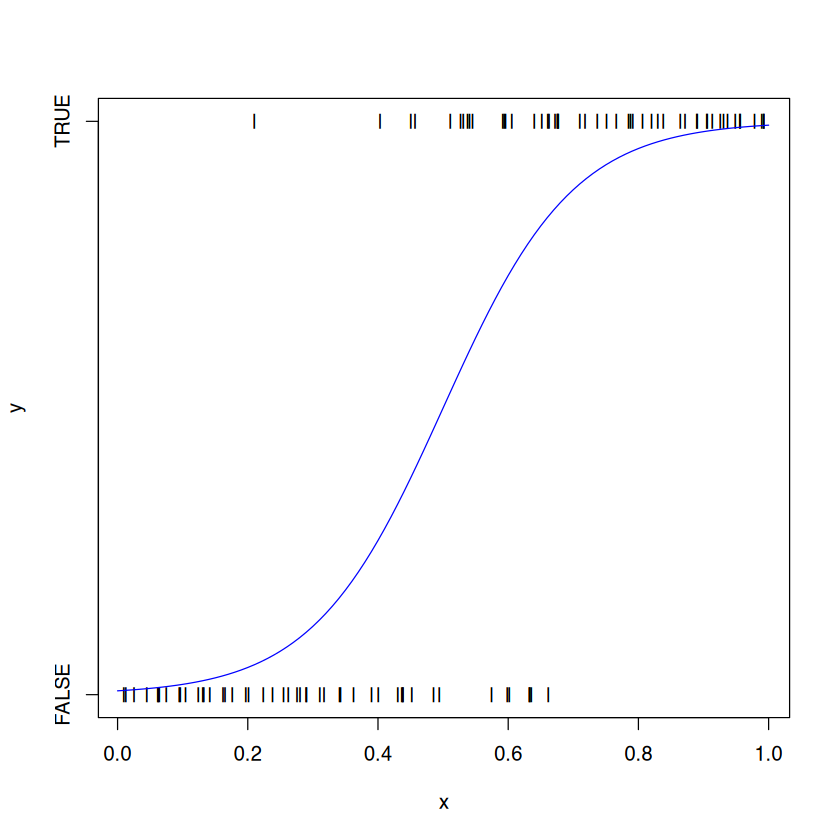

In [78]:
plot(x, y, pch = "|", yaxt = "n")  # you can find help about pch and yaxt with ?par
axis(2, at = c(0, 1), c("FALSE", "TRUE"))  # plots tick labels on the y-axis
curve(prob.true, from = 0, to = 1, col = "blue", add = TRUE)

The probability density for class label `TRUE` is equal to 0.5 for x = 0.5,
smaller for smaller x and larger for larger x. Therefore the Bayes Decision
boundary is at x = 0.5. The Bayes Error Rate can thus be computed by integrating
the probability density function from 0 to 0.5 and multiplying the result by 2,
because we predict as many FALSEs incorrectly as we predict TRUEs incorrectly.
The result is $\frac2{10}(log(2) - log(1 + e^{-5})$.
We can also estimate the Bayes Error Rate with many samples.

In [79]:
x <- runif(10^6)
p <- prob.true(x)
y <- p > runif(10^6)
y.pred <- p > 0.5
mean(y != y.pred)

[1] 0.137313

Does your estimation reach approximately the same result as the theoretical
prediction above?

Let us create now an artificial two dimensional data set.

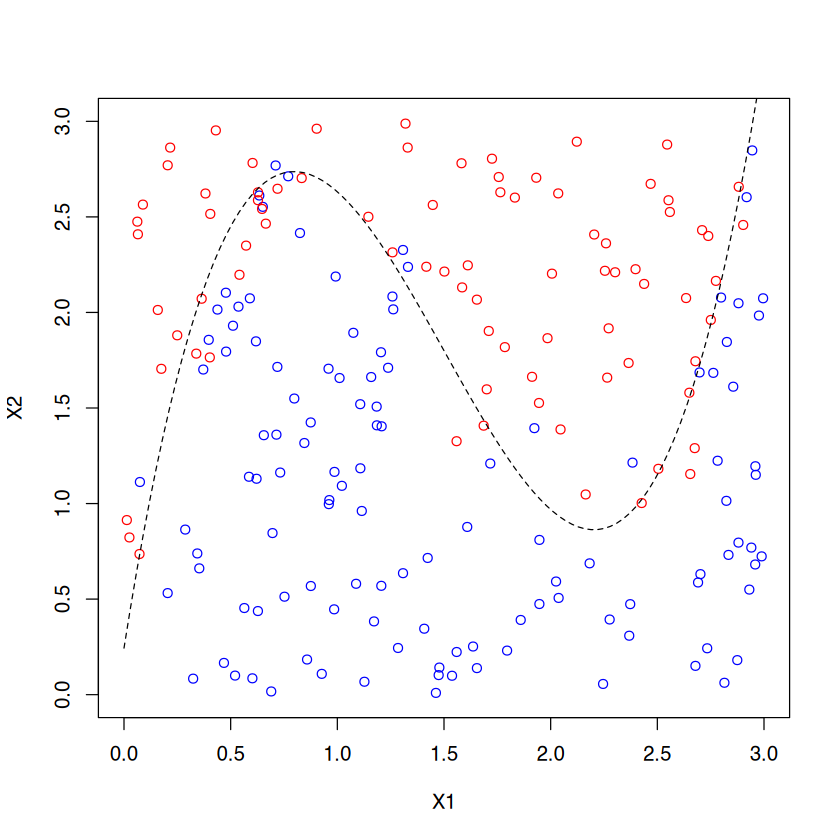

In [80]:
bayes.boundary <- function(x) {(6*x - 9)^3/160 - (5*x - 12)/2.5}
prob.true <- function(data) { 1 / (1 + exp(-5*(bayes.boundary(data$X1) - data$X2))) }
set.seed(9)
N <- 200
x <- data.frame(X1 = 3*runif(N), X2 = 3*runif(N))
y <- prob.true(x) > runif(N)
plot(x[y,], col = 'blue', xlim = c(0, 3), ylim = c(0, 3)) # plot all points with class label TRUE
points(x[!y,], col = 'red') # !y means "not y", i.e. select all points with class label FALSE
curve(bayes.boundary, from = 0, to = 3, lty = 2, add = T)

We will use again the `kNN` function to perform classification, this time with
the Euclidean distance in 2 dimensions to find the nearest neighbours.

In [81]:
kNN <- function(x0, x, y, k = 2) {
    d = sqrt((x[,1] - x0[1])^2 + (x[,2] - x0[2])^2) # Euclidean distance in 2D
    o = order(d)
    mean(y[o[1:k]])
}
grid <- expand.grid(X1 = seq(0, 3, length.out = 100), X2 = seq(0, 3, length.out = 100))
prob.estimated <- apply(grid, 1, kNN, x, y, 5) # 5 nearest neighbours
y.pred <- prob.estimated > 0.5

In the third to last line we created points that lie on an evenly spaced grid.
In the second to last line we use the `apply` function along dimension 1 (rows) of the
grid, to compute the estimated probability for all points on the grid.
You may want to run `tail(prob.estimated)` and `prob.true(tail(grid))` to see
how well the estimated probablities match the true probabilities.
In the last line we compute the predicted class labels by applying the Bayes
Classifier to the estimated probabilities.

Let us plot everything.

In [82]:
plot(grid[y.pred,], col = 'yellow', pch = '*', xlim = c(0, 3), ylim = c(0, 3))
points(grid[!y.pred,], col = 'green', pch = '*')
points(x[y,], col = 'blue')
points(x[!y,], col = 'red')
curve(bayes.boundary, from = 0, to = 3, lty = 2, add = T)

You can see that the kNN decision boundary (the Bayes decision boundary based on
the estimated probability density; boundary between green and yellow areas)
follows the Bayes decision boundary of the data generating density not perfectly
but captures the main trend.

Let us compute the training and the test error.

In [83]:
training.error <- mean(y != (apply(x, 1, kNN, x, y, k = 5) > 0.5))
cat(c("training error: ", training.error, "\n"))
N.test <- 10^3
x.test <- data.frame(X1 = 3*runif(N.test), X2 = 3*runif(N.test))
y.test <- prob.true(x.test) > runif(N.test)
test.error <- mean(y.test != (apply(x.test, 1, kNN, x, y, k = 5) > 0.5))
cat(c("test error: ", test.error, "\n"))

training error:  0.09 
test error:  0.137 


Once you feel ready, please head over to the [quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1094719).

## Assessment of Binary Classification

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/4ac6ada5" frameborder="0" allow="fullscreen"></iframe>')

Let us go back to the simple artificial classification example and compute the
confusion matrix.

In [84]:
set.seed(321)
prob.true <- function(x, b = 10) { 1 / (1 + exp(-b*(x - 0.5))) }
x <- runif(100)
y <- prob.true(x) > runif(100)
y.pred <- prob.true(x) > .5    # decision threshold 0.5
TP <- sum(y.pred[y])
FP <- sum(y.pred[!y])
TN <- sum(!y.pred[!y])
FN <- sum(!y.pred[y])
matrix(c(TN, FP, FN, TP), 2, 2)

[,1] [,2]
[1,] 42    4  
[2,]  7   47

Instead of computing the true/false positives/negatives manually, we could have
used the function `table`.

In [85]:
table(y.pred, y)

       y
y.pred  FALSE TRUE
  FALSE    42    4
  TRUE      7   47

Play a bit with different values of the decision threshold and observe how the
confusion matrix changes.

Next we will compute and plot the false positive rate, the false negative rate,
the true positive rate and the error rate.

In [86]:
x <- runif(10^4)
y <- prob.true(x) > runif(10^4)
error.rates <- function(threshold, x, y) {
        y.pred <- prob.true(x) > threshold
        TP <- sum(y.pred[y])
        FP <- sum(y.pred[!y])
        TN <- sum(!y.pred[!y])
        FN <- sum(!y.pred[y])
        c(FP/(TN + FP), FN/(TP + FN), TP/(TP + FN), (FP + FN)/length(y))
    }
thresholds <- seq(0, 1, length.out = 100)
result <- sapply(thresholds, error.rates, x, y)
plot(thresholds, result[1,], type = 'l', col = 'red', ylab = "error rate", xlab = "decision threshold")
lines(thresholds, result[2,], col = 'blue')
lines(thresholds, result[3,], col = 'darkgreen')
lines(thresholds, result[4,])
legend("center", legend = c("false positive rate", "false negative rate", "true positive rate", "error rate"), col = c('red', 'blue', 'darkgreen', 'black'), lty = 1)

Let us now plot the ROC curve.

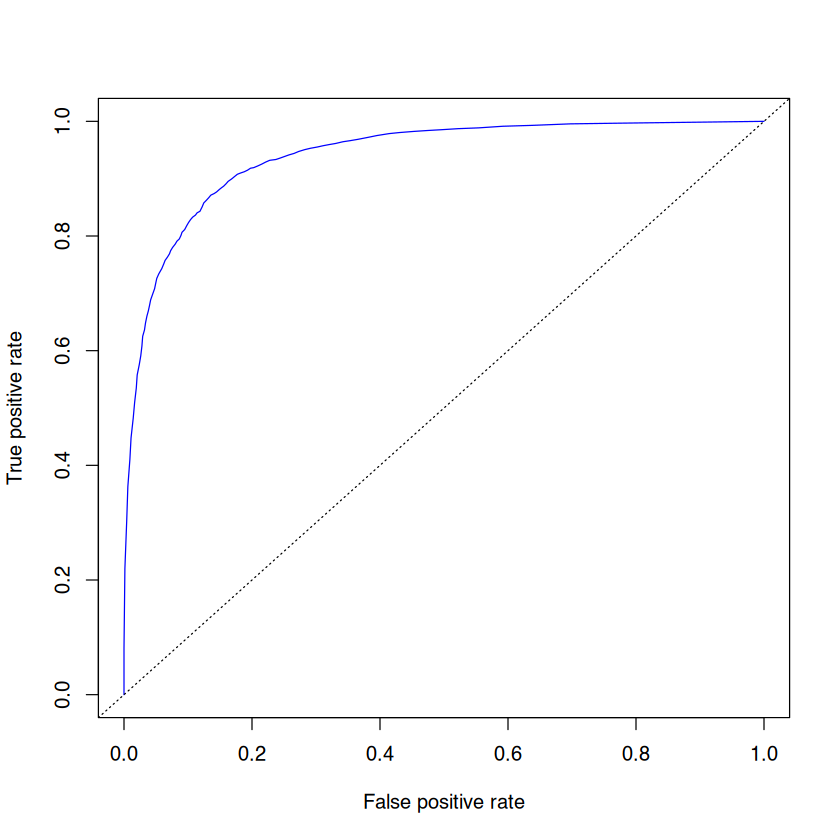

In [87]:
plot(result[1,], result[3,], type = 'l', col = 'blue', ylab = "True positive rate", xlab = "False positive rate")
abline(c(0, 0), c(1, 1), lty = 3)

Instead of computing the error rates we could have used the `ROCR` library.
Note that we have to provide the predicted probabilities and the class labels to
the `prediction` function below.

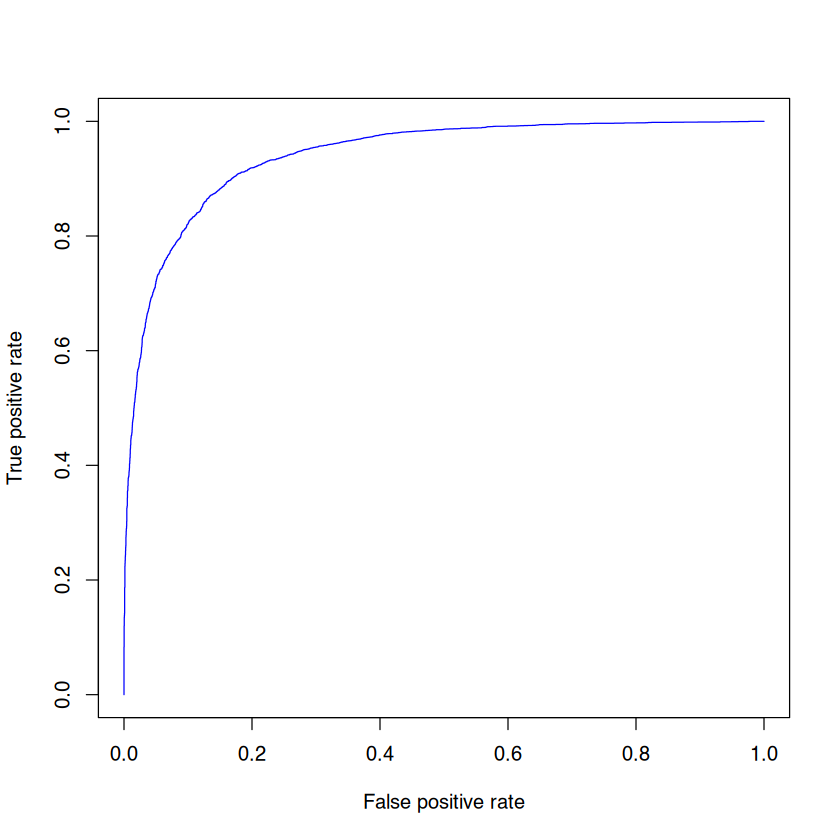

In [88]:
library(ROCR)
ROCR.pred <- prediction(prob.true(x), y)
ROCR.perf <- performance(ROCR.pred, 'tpr', 'fpr')
plot(ROCR.perf, col = 'blue')

The ROCR library has also a convenient function to compute the area under the
ROC curve (AUC)

In [89]:
performance(ROCR.pred, 'auc')@y.values

[[1]]
[1] 0.9403169

If you want to know more about the `@` run `?"@"`. If you want to find all slot
names use `names(attributes(performance(ROCR.pred, 'auc')))`.

Finally, let us plot the ROC and compute the AUC for artificial data sets with
different Bayes error rate. We will use the following densities to generate the
data

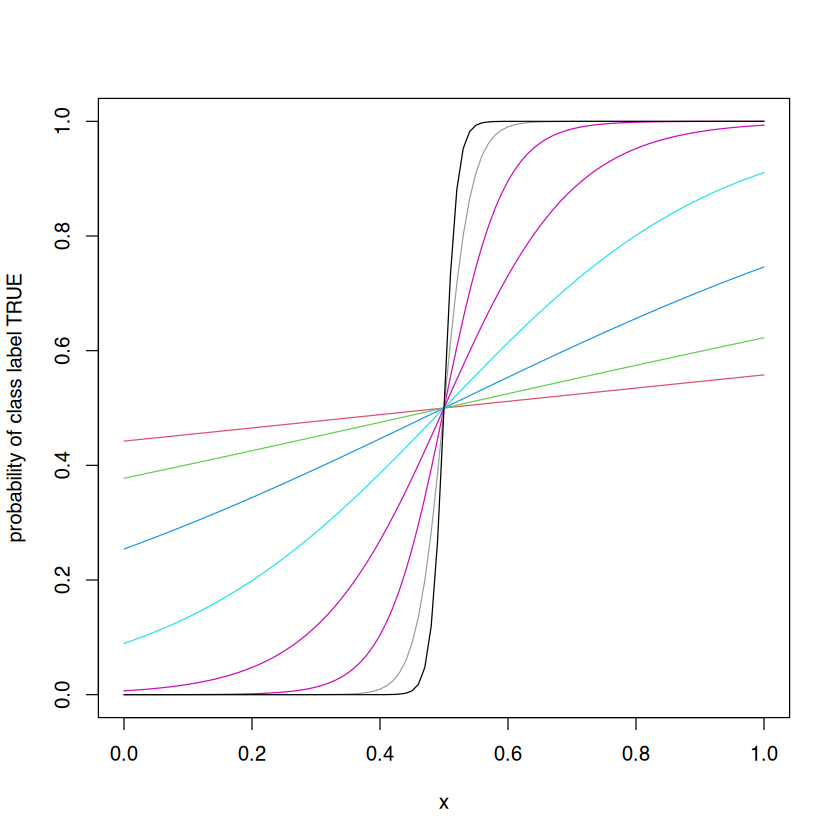

In [90]:
for(i in seq(-1, 2, length.out = 10)) {
    f <- function(x) prob.true(x, 10^i)
    curve(f, from = 0, to = 1, add = i != -1, col = 3*(i + 1), ylim = c(0, 1), ylab = "probability of class label TRUE")
}

Which of these data generating functions will lead to the lowest/highest Bayes
error rate?
Now take a piece of paper and draw a prediction for the ROC curve for data
generated with the function shown in black and the function shown in red.
For which one of those two do you expect to get the higher AUC?

Once you have made your predictions, run the following cell.

AUC(b =  0.1 ) =  0.515228205372214 
AUC(b =  0.215443469003188 ) =  0.52438619538806 
AUC(b =  0.464158883361278 ) =  0.525077028620369 
AUC(b =  1 ) =  0.584017681768176 
AUC(b =  2.15443469003188 ) =  0.673596027080295 
AUC(b =  4.64158883361278 ) =  0.813775139997101 
AUC(b =  10 ) =  0.935383506348203 
AUC(b =  21.5443469003188 ) =  0.984033974241319 
AUC(b =  46.4158883361278 ) =  0.996698438811437 
AUC(b =  100 ) =  0.999346926144651 


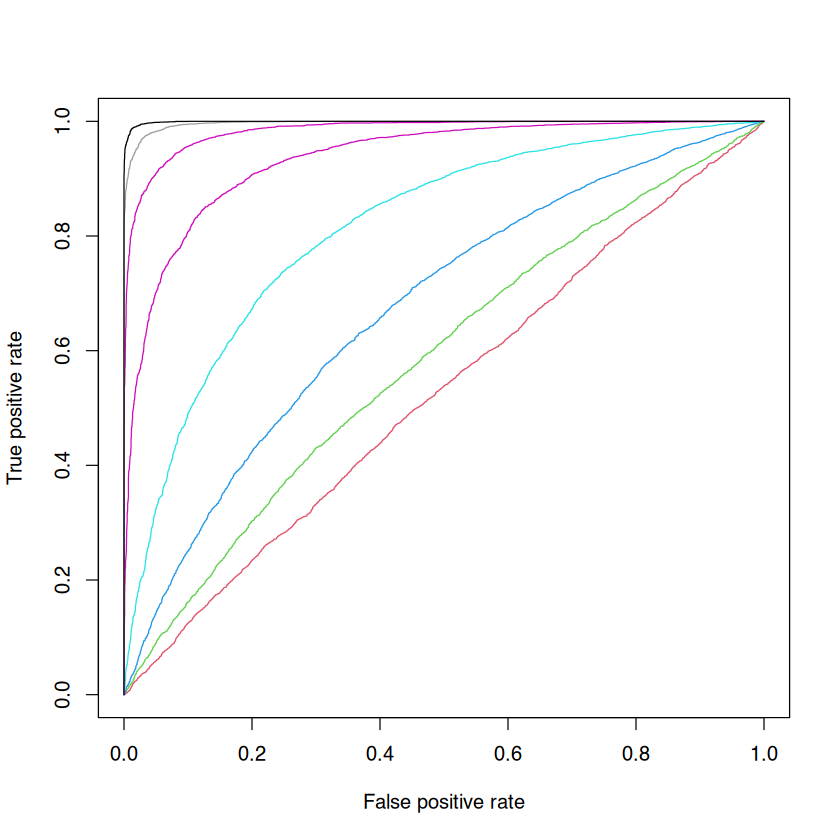

In [91]:
x <- runif(10^4)
for(i in seq(-1, 2, length.out = 10)) {
    p <- prob.true(x, 10^i)
    y <- p > runif(10^4)
    ROCR.pred <- prediction(p, y)
    cat(c("AUC(b = ", 10^i, ") = ", performance(ROCR.pred, 'auc')@y.values[[1]], "\n"))
    plot(performance(ROCR.pred, 'tpr', 'fpr'), add = i != -1, col = 3*(i + 1))
}

To finish this section you can move over to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1094727).

## Logistic Regression, Linear and Quadratic Discriminant Analysis

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/47ce0644" frameborder="0" allow="fullscreen"></iframe>')

We will run logistic regression on an artificially generated data set with two
input variables.

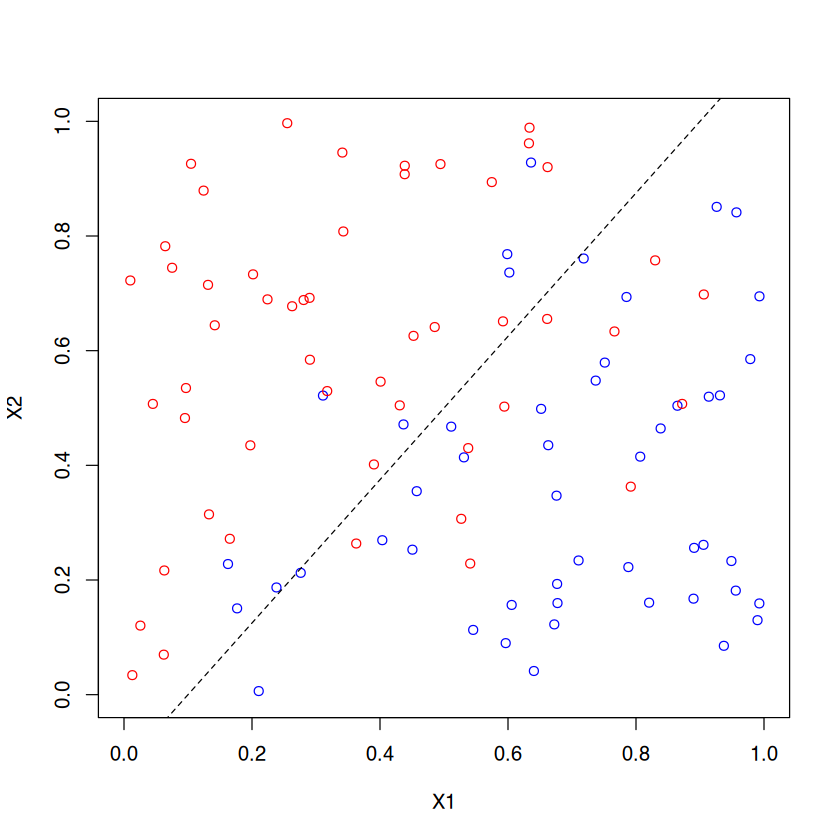

In [92]:
set.seed(321)
prob.true <- function(x, a = -1, b = 10, c = -8) { 1 / (1 + exp(-a - b * x$X1 - c*x$X2)) }
data.train <- data.frame(X1 = runif(100), X2 = runif(100))
data.train$Y <- prob.true(data.train) > runif(100) # add column Y to data.train
plot(data.train[data.train$Y, c("X1", "X2")], col = 'blue', xlim = c(0, 1), ylim = c(0, 1))
points(data.train[!data.train$Y, c("X1", "X2")], col = 'red')
boundary.from.params <- function(p) c(-p[1]/p[3], -p[2]/p[3]) # intercept and slope
abline(boundary.from.params(c(-1, 10, -8)), lty = 2) # Bayes decision boundary

Now we use the function `glm` with keyword argument `family = 'binomial'` to fit
the training data.

In [93]:
fit <- glm(Y ~ X1 + X2, data = data.train, family = 'binomial')
fit


Call:  glm(formula = Y ~ X1 + X2, family = "binomial", data = data.train)

Coefficients:
(Intercept)           X1           X2  
    -0.6273       6.2940      -5.4954  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    138.6 
Residual Deviance: 78.78 	AIC: 84.78

The formula says that `X1` and `X2` are predictors and `Y` is the response.
The data is taken from the corresponding columns in `data.train`.
The `Coefficients` returned by the fit are $\beta_0 = -0.6273$ (Intercept),
$\beta_1 = 6.2940$ (X1) and $\beta_2 = -5.4954$ (X2). As you can see, they are
somewhat close to the parameters we used to generate the data, i.e. $\beta_0 =
-1$, $\beta_1 = 10$ and $\beta_2  = -8$.

You may want to play around a bit with different values for the size of the
training set and different values for `a`, `b`, `c` and the random seeds in the
data generation process and see how the fitted parameters vary.

The fit can also be used to make predictions on a test set.

In [94]:
data.test <- data.frame(X1 = runif(10^4), X2 = runif(10^4))
y.prob.true <- prob.true(data.test)
data.test$Y <- y.prob.true > runif(10^4)
y.prob.fitted <- predict(fit, data.test, type = "response")

The `predict` function takes as arguments the `fit` and the test input as a data
frame with the same column name (`X` here) as was used for the input in `data =
data.frame(X = x, Y = y)` in the fit. The argument `type = "response"` makes the
predict function return probabilities.

We can use now the predicted class probabilities to compute the AUC and plot the
ROC curve.

[[1]]
[1] 0.9454462

[[1]]
[1] 0.9460407



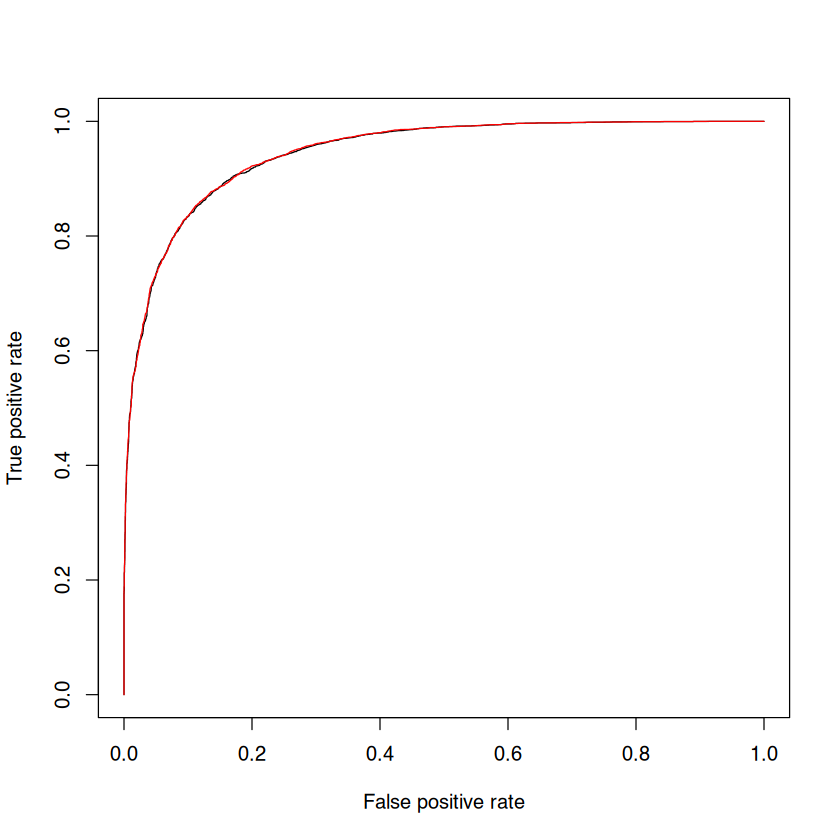

In [95]:
ROCR.pred.fitted <- prediction(y.prob.fitted, data.test$Y)
ROCR.pred.true <- prediction(y.prob.true, data.test$Y)
plot(performance(ROCR.pred.fitted, 'tpr', 'fpr'))
plot(performance(ROCR.pred.true, 'tpr', 'fpr'), add = TRUE, col = 'red')
print(performance(ROCR.pred.fitted, 'auc')@y.values)
print(performance(ROCR.pred.true, 'auc')@y.values)

You can see that the ROC curves are almost indistinguishable and the AUC of the
fitted classifier is alsmost as high as the one of the data generating
classifier.

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/fdd0bbff" frameborder="0" allow="fullscreen"></iframe>')

Let us now fit linear and quadratic discriminant analysis to our training set.
The functions `lda` and `qda` can be found in the library `MASS`.

In [96]:
library(MASS)
lda.fit <- lda(Y ~ X1 + X2, data = data.train, method = "moment")
lda.predict <- predict(lda.fit, data.test)
ROCR.pred.lda <- prediction(lda.predict$posterior[,2], data.test$Y)
print(performance(ROCR.pred.lda, 'auc')@y.values)

[[1]]
[1] 0.946042



The `predict` function for an LDA fit returns predicted classes and
probabilities for the different classes. We extract the probabilities for class
label `TRUE` with `lda.predict$posterior[,2]`.

In [ ]:
IRdisplay::display_html('<iframe width="640" height="360" src="https://tube.switch.ch/embed/3d7a7937" frameborder="0" allow="fullscreen"></iframe>')

For QDA we do the same.

In [97]:
qda.fit <- qda(Y ~ X1 + X2, data = data.train, method = "moment")
qda.predict <- predict(qda.fit, data.test)
ROCR.pred.qda <- prediction(qda.predict$posterior[,2], data.test$Y)
print(performance(ROCR.pred.qda, 'auc')@y.values)

[[1]]
[1] 0.9458032



Let us now plot everything.
For logistic regression we extract explicitely the parameters of the
decision boundary, whereas for LDA and QDA we predict the probabilities of class label
`TRUE` on a grid and plot the countour line for probability level 0.5.

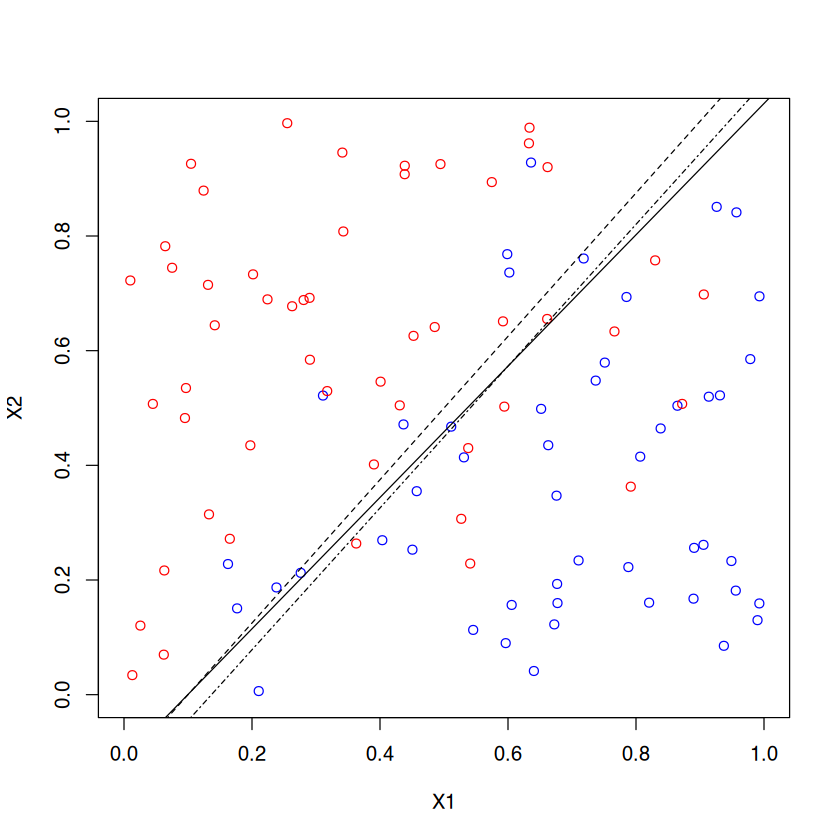

In [98]:
plot(data.train[data.train$Y, c("X1", "X2")], col = 'blue', xlim = c(0, 1), ylim = c(0, 1))
points(data.train[!data.train$Y, c("X1", "X2")], col = 'red')
abline(boundary.from.params(c(-1, 10, -8)), lty = 2) # Bayes decision boundary
abline(boundary.from.params(coefficients(fit)), col = "darkgreen") # logistic regression decision boundary
grid <- expand.grid(X1 = seq(0, 1, length.out = 100), X2 = seq(0, 1, length.out = 100))
lda.pred <- predict(lda.fit, grid)
contour(seq(0, 1, length.out = 100), seq(0, 1, length.out = 100),
        matrix(lda.pred$posterior[,2], 100, 100), levels = c(0.5), add = T, col = "blue")
qda.pred <- predict(qda.fit, grid)
contour(seq(0, 1, length.out = 100), seq(0, 1, length.out = 100),
        matrix(qda.pred$posterior[,2], 100, 100), levels = c(0.5), add = T, col = "orange")

Once you feel ready, move over to the
[quiz](https://moodle.epfl.ch/mod/quiz/view.php?id=1094729).

## Exercises

**Q1.** We revisit the bias-variance decomposition.

(a) Provide a sketch of typical (squared) bias, variance, training error, test error, and Bayes (or irreducible) error curves, on a single plot, as we go from less flexible statistical learning methods towards more flexible approaches. The x-axis should represent the amount of flexibility in the method, and the y-axis should represent the values for each curve. There should be five curves. Make sure to label each one.

(b) Explain why each of the five curves has the shape displayed in part (a).

**Q2.** Suppose that we take a data set with mutually distinct inputs $x_i\neq
x_j$ for $i\neq j$, divide it into equally-sized training and test sets, and
then try out two different classification procedures. First we use logistic
regression and get an error rate of 20% on the training data and 30% on the test
data. Next we use 1-nearest neighbors (i.e. $K = 1$) and get an average error
rate (averaged over both test and training data sets) of 18%. Based on these
results, which method should we prefer to use for classification of new
observations? Why?

**Q3.** Suppose we collect data for a group of students in a machine learning
class with variables $X_1 =$ hours studied, $X_2 =$ grade in statistics class,
and $Y =$ receive a 6 in the machine learning class. We fit a logistic
regression and produce estimated coefficients, $\hat{\beta}_0 = -6$,
$\hat{\beta}_1 = 0.025$, $\hat{\beta}_2 = 1$.

(a) Estimate the probability that a student who studies for 75 hours and had a
4 in the statistics class gets a 6 in the machine class.

(b) How many hours would the student in part (a) need to study to have a 50%
chance of getting an 6 in the class ?

**Q4.** We will go back to the artifical two-dimensional data set in the section
where we studied kNN classification with the Bayes decision boundary
`bayes.boundary <- function(x) {(6*x - 9)^3/160 - (5*x - 12)/2.5}`.

(a) Compute the training and test error for different values of `k` with kNN
classification. Plot training and test error as a function of `1/k` and include
as a dashed line an estimate of the Bayes Error.

(b) Plot the ROC curve and the AUC for the value of `k` that lead to the lowest
test error in (a).

(b) Fit logistic regression, LDA and QDA to the same artifical data and compute
the AUC.

**Q5.** In this exercise we will perform binary classification on the life
expectancy dataset. We will try to predict whether the life expectancy is
higher than 70 years using the predictors GDP and BMI. You can load and
clean the data set with the following commands.

In [ ]:
data <- read.csv(file.path("..", "data", "life_expectancy.csv"))
data <- na.omit(data[,c("GDP", "BMI", "LifeExpectancy")])
data$LifeExpectancy70 <- data$LifeExpectancy > 70

(a) Plot the dataset with different colours for the samples with life expectancy
larger than 70 than for those with life expectancy below 70.

(b) Split the data set into a training and a test set.

(c) Fit logistic regression to the training set and plot the decision boundary
together with the data. Hint: you may want to use the function
`boundary.from.params` that we defined above.

(d) Compute the confusion matrix for the logistic regression from (c) and
decision threshold 0.4 on the training and the test set.

(e) Fit LDA and QDA to the data, compute their AUC on the test set and compare
it to the AUC of logistic regression.

(f) Group the life expectancy into decades with the following command

In [ ]:
data$LifeExpectancyDecades <- as.factor(signif(data$LifeExpectancy, -1))

Perform a linear discriminant analysis with `GDP` and `BMI` as predictors and
`LifeExpectancyDecades` as response on the full data set.

(g) Which class would the LDA fit from (f) predict for GDP = 20000 and BMI = 22?